In [1]:
print("Hello, World!")

Hello, World!


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for multiple tockets
#50 tockets
# Scarica lista S&P500 da Wikipedia
tickers = pd.read_csv("/home/ceci/ProblemSolving/notebooks/constituents.csv")["Symbol"].tolist()

# Alcuni ticker hanno un punto (es. BRK.B, BF.B) → Yahoo li vuole con trattino
tickers = [t.replace(".", "-") for t in tickers]
data = yf.download(tickers, start="2023-01-01", end="2025-01-01")['Close']
data = data.dropna(axis=1, how='all')

/tmp/ipykernel_14545/1040873868.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2023-01-01", end="2025-01-01")['Close']
[*********************100%***********************]  503 of 503 completed


In [3]:
nan_frac = data.isna().mean()
# tieni solo colonne con meno del 5% di NaN
ok_cols = nan_frac[nan_frac <= 0.05].index
data_clean = data[ok_cols]
data_clean = data_clean.fillna(method='ffill').fillna(method='bfill')
subset = data_clean.iloc[:, :100]

/tmp/ipykernel_14545/1858708222.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean = data_clean.fillna(method='ffill').fillna(method='bfill')


first 5 rows of returns:
 Ticker             A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2023-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2023-01-04  0.660883  0.660106  0.552953  1.792072  1.232286  0.267464   
2023-01-05  0.185657 -0.899635 -0.111470 -0.511850 -0.323237  0.119841   
2023-01-06 -1.768664  2.588776  1.307165  0.345651  1.143695  0.936904   
2023-01-09 -0.069882  0.199354 -2.162513  0.300300 -0.147138 -1.335230   

Ticker           ACN      ADBE       ADI       ADM  ...      CINF        CL  \
Date                                                ...                       
2023-01-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2023-01-04 -0.271797  0.579761  1.121618 -1.907067  ...  1.423304  0.606601   
2023-01-05 -1.663897 -1.795497 -2.127149 -1.286397  ...  0.149037 -1.431038   
2023-01-06  1.550975  0.570562  1.931652  1.124922  ...  1.8

/tmp/ipykernel_14545/2513479068.py:24: RuntimeWarning: invalid value encountered in sqrt
  mp = 1/(2*np.pi) * np.sqrt((bounds[1]-eigvals)*(eigvals-bounds[0])) / eigvals


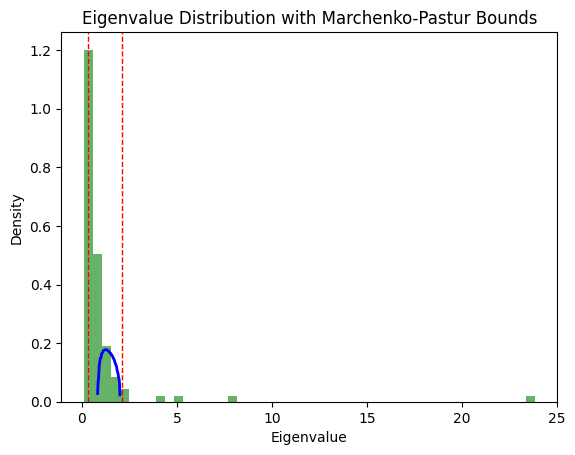

C shape: (100, 100)


In [9]:
#marchenko-pastur on real data
import sys
sys.path.append("../src")
from finrmt.data import returns
from finrmt.rmt import mp_bounds

#for multiple tockets defined before

ret = returns(subset)

R = ret.dropna(how="any").to_numpy(dtype=float)   # shape: (T, N)
print("first 5 rows of returns:\n", ret.head())
T, N = R.shape
bounds = mp_bounds(N, T, sigma2=1.0)
print("Marchenko-Pastur bounds:", bounds)
print("R shape:", R.shape)
#print("First 5 rows of R:\n", R[:5])

C = (1/T) * R.T @ R   # shape: (N, N)
eigvals = np.linalg.eigvalsh(C)
plt.hist(eigvals, bins=50, density=True, alpha=0.6, color='g')
plt.axvline(bounds[0], color='r', linestyle='dashed', linewidth=1)
plt.axvline(bounds[1], color='r', linestyle='dashed', linewidth=1)
mp = 1/(2*np.pi) * np.sqrt((bounds[1]-eigvals)*(eigvals-bounds[0])) / eigvals
x = np.linspace(bounds[0], bounds[1], 100)
plt.plot(x, mp, 'b-', lw=2)
plt.title("Eigenvalue Distribution with Marchenko-Pastur Bounds")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.show()
print("C shape:", C.shape)


confronto con matrice gaussiana

/tmp/ipykernel_14545/383135112.py:7: RuntimeWarning: invalid value encountered in sqrt
  mp = (1/(2*np.pi*N/T)) * np.sqrt((bounds[1]-eigvals_gauss)*(eigvals_gauss-bounds[0])) / eigvals_gauss


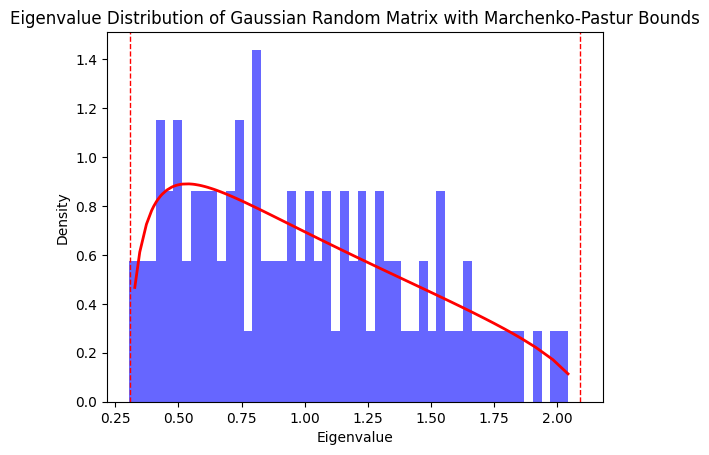

/tmp/ipykernel_14545/383135112.py:25: RuntimeWarning: invalid value encountered in sqrt
  mp = (1/(2*np.pi*N/T)) * np.sqrt((bounds[1]-np.array(all_eigvals))*(np.array(all_eigvals)-bounds[0])) / np.array(all_eigvals)


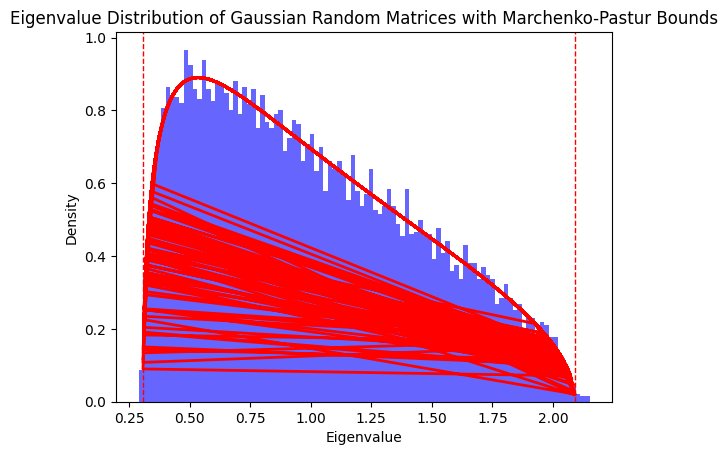

In [6]:

R_gauss = np.random.normal(0, 1, size=(T, N))
C_gauss = (1/T) * R_gauss.T @ R_gauss
eigvals_gauss = np.linalg.eigvalsh(C_gauss)
plt.hist(eigvals_gauss, bins=50, density=True, alpha=0.6, color='b')
plt.axvline(bounds[0], color='r', linestyle='dashed', linewidth=1)
plt.axvline(bounds[1], color='r', linestyle='dashed', linewidth=1)
mp = (1/(2*np.pi*N/T)) * np.sqrt((bounds[1]-eigvals_gauss)*(eigvals_gauss-bounds[0])) / eigvals_gauss
plt.plot(eigvals_gauss, mp, 'r-', lw=2)
plt.title("Eigenvalue Distribution of Gaussian Random Matrix with Marchenko-Pastur Bounds")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.show()

#generate many gaussians
num_simulations = 100
all_eigvals = []
for _ in range(num_simulations):
    R_gauss = np.random.normal(0, 1, size=(T, N))
    C_gauss = (1/T) * R_gauss.T @ R_gauss
    eigvals_gauss = np.linalg.eigvalsh(C_gauss)
    all_eigvals.extend(eigvals_gauss)
plt.hist(all_eigvals, bins=100, density=True, alpha=0.6, color='b')
plt.axvline(bounds[0], color='r', linestyle='dashed', linewidth=1)
plt.axvline(bounds[1], color='r', linestyle='dashed', linewidth=1)
mp = (1/(2*np.pi*N/T)) * np.sqrt((bounds[1]-np.array(all_eigvals))*(np.array(all_eigvals)-bounds[0])) / np.array(all_eigvals)
plt.plot(np.array(all_eigvals), mp, 'r-', lw=2)
plt.title("Eigenvalue Distribution of Gaussian Random Matrices with Marchenko-Pastur Bounds")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.show()


prova a togliere la standardizzazione